In [1]:
#Import Packages
import keras
from keras.datasets import imdb
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import Model
import graphviz
from graphviz import Digraph
import numpy as np
from gensim.parsing.preprocessing import remove_stopwords
import random
import pickle
import pandas as pd
#Visualisation Libraries
import matplotlib.pyplot as plt   
import seaborn as sns
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Using TensorFlow backend.


In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:

INDEX_FROM=3   # word index offset
(X_train, y_train), (X_test, y_test) = imdb.load_data(index_from=INDEX_FROM) 

17465344/17464789 [==============================] - 1s 0us/step


In [4]:
word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
id_to_word = {value:key for key,value in word_to_id.items()}
vocab = len(id_to_word)


1646592/1641221 [==============================] - 0s 0us/step


In [5]:
total_sentence_length = 0
for ex in X_train:
  s= ' '.join(id_to_word[id] for id in ex if id!=0)
  total_sentence_length = total_sentence_length + len(s.split())
print('average length: ', total_sentence_length/ len(X_test))  

average length:  238.71488


In [0]:
max_words = 200 #average length of a review in training set
#padding the review where words<max_words
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [0]:
#Model Parameters
embedding_dim = 16
hidden_dim = 10

In [8]:
#Model Creation
model = Sequential()
model.add(Embedding(vocab, embedding_dim , input_length=max_words))
model.add(Flatten())
model.add(Dense(hidden_dim, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 16)           1417392   
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                32010     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,449,413
Trainable params: 1,449,413
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)
# Final evaluation of the model on test dataset
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Use tf.cast instead.
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
 - 6s - loss: 0.5413 - acc: 0.7150 - val_loss: 0.3216 - val_acc: 0.8620
Epoch 2/2
 - 5s - loss: 0.2036 - acc: 0.9235 - val_loss: 0.2969 - val_acc: 0.8743
Accuracy: 87.43%


In [0]:
#To find which neurons fire for particularly positive and negative samples

In [0]:
positive_train = [] #No of positive samples that are predicted correctly
negative_train = [] #No of negative examples that are predicted correctly
for i in range(len(X_train)):
  pred = model.predict_classes(np.array([X_train[i]])).astype(int)
  pred = pred[0][0]
  if pred == y_train[i]:
    if pred == 0:
      negative_train.append(X_train[i])
    else:
      positive_train.append(X_train[i])

In [12]:
print(len(positive_train))
print(len(negative_train))

12127
12337


In [18]:
positive_hidden_values = [] #3 layer output values
for i,doc in enumerate(positive_train[:1000]):
  third_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[2].output)
  third_layer_output = (third_layer_model.predict(np.array([doc]))).tolist()[0]
  positive_hidden_values.append(third_layer_output)
  if i%100 == 0:
    print("Done for {} values".format(i))


Done for 0 values
Done for 100 values
Done for 200 values
Done for 300 values
Done for 400 values
Done for 500 values
Done for 600 values
Done for 700 values
Done for 800 values
Done for 900 values
Done for 0 values
Done for 100 values
Done for 200 values
Done for 300 values
Done for 400 values
Done for 500 values
Done for 600 values
Done for 700 values
Done for 800 values
Done for 900 values


In [0]:
positive_neuron_activation = []
neurons = [0,1,2,3,4,5,6,7,8,9]
for index in neurons:
  average = sum(activation[index] for activation in positive_hidden_values) / 5000
  positive_neuron_activation.append(average)

In [26]:
negative_hidden_values = [] #3 layer output values
for i,doc in enumerate(negative_train[5001:7001]):
  third_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[2].output)
  third_layer_output = (third_layer_model.predict(np.array([doc]))).tolist()[0]
  negative_hidden_values.append(third_layer_output)
  if i%100 == 0:
    print("Done for {} values".format(i))

Done for 0 values
Done for 100 values
Done for 200 values
Done for 300 values
Done for 400 values
Done for 500 values
Done for 600 values
Done for 700 values
Done for 800 values
Done for 900 values
Done for 1000 values
Done for 1100 values
Done for 1200 values
Done for 1300 values
Done for 1400 values
Done for 1500 values
Done for 1600 values
Done for 1700 values
Done for 1800 values
Done for 1900 values


In [0]:
negative_neuron_activation = []
neurons = [0,1,2,3,4,5,6,7,8,9]
for index in neurons:
  average = sum(activation[index] for activation in negative_hidden_values) / 5000
  negative_neuron_activation.append(average)

In [28]:
#Activations of third layer
print(positive_neuron_activation)
print(negative_neuron_activation)

[0.03651683658920229, 0.04089192811399698, 0.5639244415521621, 0.040775707759708166, 0.028710868119448424, 0.04528546242564917, 0.03579898765683174, 0.5411912673473358, 0.03967421474456787, 0.03647863399684429]
[1.0463367608428003, 1.1156995064139366, 0.9809514248751103, 1.101806180602312, 0.9863323745965957, 1.3981970863699913, 1.2225323523521423, 0.9508093735650182, 1.039462924259901, 1.135302081632614]


In [31]:
print(np.argsort(negative_neuron_activation))
print(np.sort(negative_neuron_activation))

[7 2 4 8 0 3 1 9 6 5]


array([0.95080937, 0.98095142, 0.98633237, 1.03946292, 1.04633676,
       1.10180618, 1.11569951, 1.13530208, 1.22253235, 1.39819709])

In [0]:
#function to create neural graph
def trace_path(sentence ,masked_inputs , activation_values , final_output , masked_flag):
  dot = Digraph(comment='NN' )
  vocabulary = sentence.split()
  node_index = 1
  input_index = 1
  hidden_index = 7
  ip_node = [] #list of input nodes names to connect to hidden layer nodes
  if masked_flag:
    no_input_nodes = 6 - len(masked_inputs)
    for i in range(no_input_nodes):
      node_index = input_index
      ip_node.append(str(node_index))
      while(True):
        word = random.choice(vocabulary)
        if word not in masked_inputs:
          break
        else:
          continue
      dot.node(str(node_index), word)
      input_index+=1
    for i in range(len(masked_inputs)):
      node_index = input_index
      ip_node.append(str(node_index))
      dot.node(str(node_index), masked_inputs[i])
      input_index+=1
  else:
    no_input_nodes = 6
    for i in range(no_input_nodes):
      node_index = input_index
      ip_node.append(str(node_index))
      while(True):
        word = random.choice(vocabulary)
        if word not in masked_inputs:
          break
        else:
          continue
      dot.node(str(node_index), word)
      input_index+=1
  node_index = input_index
  ip_node.append(str(node_index))
  dot.node(str(node_index), '.......')
  predicted_category = 'Positive' if final_output[0]>=0.5 else 'Negative'
  if predicted_category == 'Positive':
    dot.node('o', 'Output - Positive',color="#000000", fillcolor="#96a32b" , style='filled')
  else:
    dot.node('o', 'Output - Negative',color="#000000", fillcolor="#ae4949" , style='filled')
  for i,op in enumerate(activation_values):
    node_index= hidden_index+1
    hidden_index+=1
    current_node = str(node_index)
    if op == 0.0:
      clr = "#FDFEFE"   
    elif op<=0.5:
      clr = "#D6EAF8"
    elif op<=1.0:
      clr = "#85C1E9"
    elif op<=2.0:
      clr="#2E86C1"
    elif op<=3.0:
      clr="#21618C"
    elif op>3.0:
      clr="#566573" 
    dot.node(current_node,'N'+str(i+1) , color="#000000", fillcolor=clr, style='filled')
    for nd in ip_node:
      dot.edge(nd, current_node)
    if op >= 3.0:
      edge_color = '#ff3300'
    if op >= 2.0:
      edge_color = '#ff6600'
    elif op >= 1.0:
      edge_color = '#ff9999'
    else:
      edge_color="#ffcc99"
    dot.edge(current_node, 'o' , label=str('{0:.2f}'.format(op)) , color = edge_color ) 
  #dot.graph_attr['rankdir'] = 'LR'
  dot.graph_attr['ordering']="out"
  return dot  


<START> laputa castle in the sky is the bomb the message is as strong as his newer works and more pure fantastic and flying pirates how could it be any better the art is totally amazing and the soundtrack which is reused many times after this im not sure if this was the first time i heard it and evokes in me the most emotional sentimental response of any movie soundtrack sheeta the female lead in this movie is totally awesome and the boy pazu is also a great role model he lives on his own the plot is classic miyazaki i won't give it away but the end is really great i rank this as one of miyazaki's three best with nausicaa and spirited away also you may want to check out howl's moving castle when it comes out sometime next year i hope if you like miyazaki check this one out as it readily available in the usa enjoy piper a


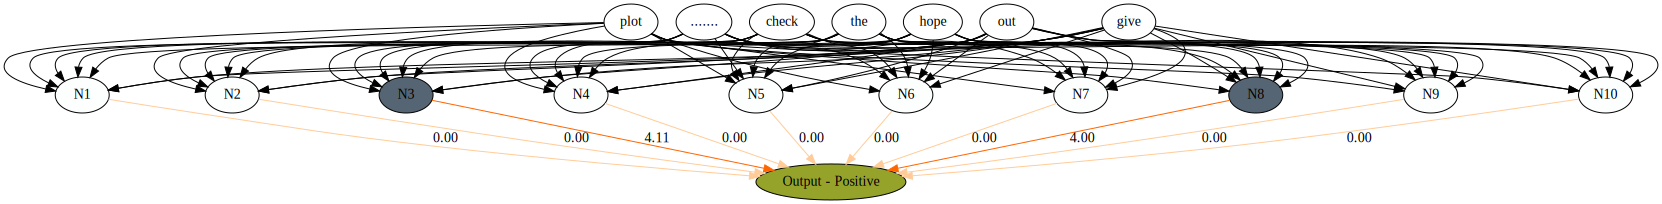

In [14]:
#TP
positive_train_index = [1 , 5 , 7]
index = random.choice(positive_train_index)
third_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[2].output)
third_layer_output = (third_layer_model.predict(np.array([positive_train[index]]))).tolist()[0]
ans = model.predict(np.array([positive_train[index]]))[0]
s=  ' '.join(id_to_word[id] for id in positive_train[index] if id!=0)
print(s)
d = trace_path(s,[] , third_layer_output , ans , False)
graphviz.Source(d)  


[0.40691435]
<START> a really realistic sensible movie by ramgopal verma no stupidity like songs as in other hindi movies class acting by nana patekar br br much similarities to real


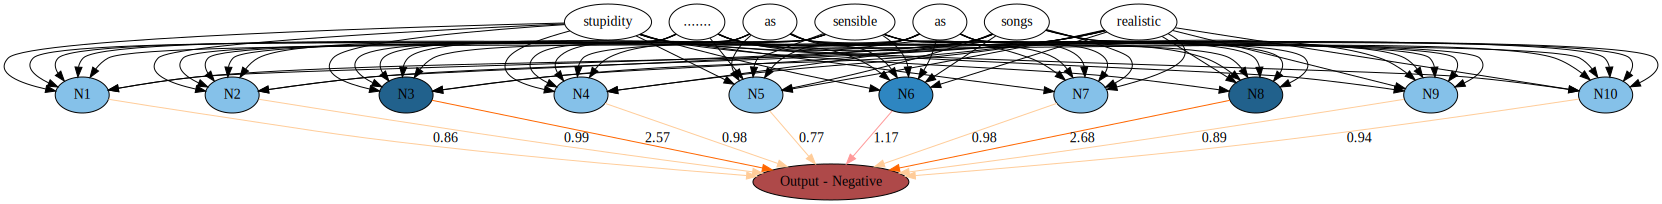

In [21]:
#FP
index = 6450
third_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[2].output)
third_layer_output = (third_layer_model.predict(np.array([X_test[index]]))).tolist()[0]
ans = model.predict(np.array([X_test[index]]))[0]
print("Output Prob : ",ans)
s=  ' '.join(id_to_word[id] for id in X_test[index] if id!=0)
print(s)
d = trace_path(s,['realistic' , 'sensible'] , third_layer_output , ans , True)
graphviz.Source(d)  


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


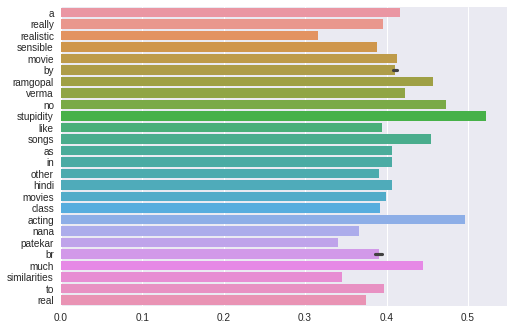

In [69]:
#Checking the output value after masking each word
word_list = []
prob_list = []
xx=np.copy(X_test[index])
last_1 = np.where(X_test[index]==1)[0][0]
for i in range(last_1+1, len(xx)):
  xx=np.copy(X_test[index])
  actual_word_id = xx[i]
  xx[i]=0
  final_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[3].output)
  final_output = (final_layer_model.predict(np.array([xx]))).tolist()[0]
  word_list.append(id_to_word[actual_word_id])
  prob_list.append(final_output[0])
mask_data = {'feature':word_list, 'probability':prob_list}
ax = sns.barplot(x="probability", y="feature", data=mask_data)  

Output prob :  [0.29914755]
<START> a really realistic sensible movie by ramgopal verma no stupidity like songs as in other hindi movies class acting by nana patekar br br much similarities to real


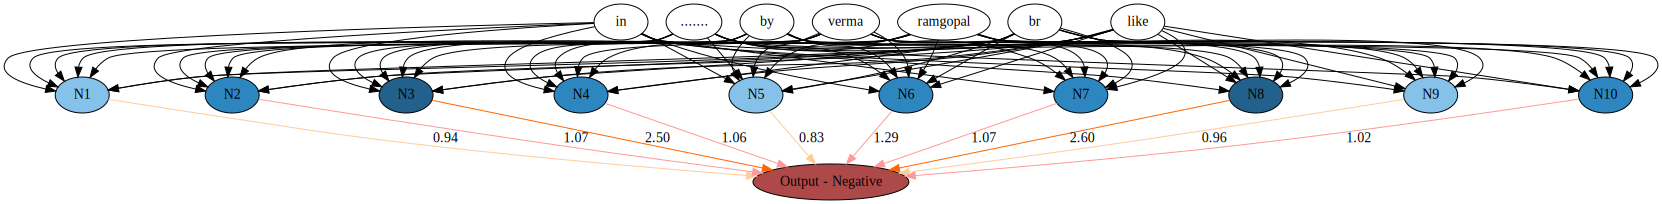

In [22]:
#After Masking
index = 6450
inp=np.copy(X_test[index])
inp[174]=0 #realistic
inp[175]=0 #sensible
third_layer_model = Model(inputs=model.input,
                               outputs=model.layers[2].output)
third_layer_output = (third_layer_model.predict(np.array([inp]))).tolist()[0]
ans = model.predict(np.array([inp]))[0]
print("Output prob : ",ans)
s=  ' '.join(id_to_word[id] for id in X_test[index] if id!=0)
print(s)
d = trace_path(s,['realistic' , 'sensible'] , third_layer_output , ans , False)
graphviz.Source(d)  

In [0]:

INDEX_FROM=3   # word index offset
(X_train, y_train), (X_test, y_test) = imdb.load_data(index_from=INDEX_FROM) 
max_words = 200 #average length of a review in training set
#padding the review where words<max_words
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [0]:
#Retraining the network with more samples of `realistic` and `sensible` to increase their positive bias
X_train_sentences = {0:[], 1:[]}
for i,xt in enumerate(X_train):
  label = y_train[i]
  if label==0:
    X_train_sentences[0].append(' '.join(id_to_word[id] for id in xt if (id!=0 and id!=1)))
  else:
    X_train_sentences[1].append(' '.join(id_to_word[id] for id in xt if (id!=0 and id!=1)))



In [0]:
#save X_train_sentences
#Save new Model
with open('/content/gdrive/My Drive/X_train_sentences.pkl', 'wb') as f:
  pickle.dump(X_train_sentences, f)

In [0]:
def convertTextToId(text, maxlen):
  id_text = [word_to_id[w] for w in text.lower().split() if w in word_to_id]
  word_count = len(id_text)
  if word_count<200:
    pad = maxlen - word_count
    padded_text = ([0]*pad)
    padded_text.extend(id_text)
  else:
    padded_text = id_text[0:200]
  return padded_text
  

In [0]:
def addToTrain(samples, X_train, y_train):
  for s in samples:

    text = convertTextToId(s[0], max_words)
    text = np.array(text, dtype=int)

    label = np.array([s[1]])

    X_train = np.vstack((X_train, text))
    y_train = np.concatenate((y_train, label))
  return X_train, y_train  
  

In [61]:
#creating new samples for training
new_samples = []
for t in X_train_sentences[1]:
  if 'realistic' in t:
    new_samples.append((t,1))
new_samples = new_samples[0:30]  
for t in X_train_sentences[1]:
  if 'sensible' in t:
    new_samples.append((t,1))
print(new_samples)    
X_train, y_train = addToTrain(new_samples, X_train, y_train)

[("and this is a very disturbing film i may be wrong but this is the last film where i considered burt reynolds an actual actor who transformed the role and delivered a message br br jon voight and ned beatty are also excellent they are unassuming and unaware businessmen wanting to enjoy the country little did they know what would happen next br br the photography and sets are realistic and natural this was before the days of wes craven br br what is most disturbing about this film is the fact that places like this still exist in america country folk still detest city people it is almost a century and a half since the civil war br br you will enjoy this film it was filmed in the rural sections of south georgia which still exist just don't drive past that to mobile alabama that area still has not been repaired since hurricane katrina 10 10", 1), ('i just watched this movie by mistake what a little gem this film made in 1956 looks and feels like a late seventies movie and is in fact bett

In [62]:
#Model Creation
model_new = Sequential()
model_new.add(Embedding(vocab, embedding_dim , input_length=max_words))
model_new.add(Flatten())
model_new.add(Dense(hidden_dim, activation='relu'))
model_new.add(Dense(1, activation='sigmoid'))
model_new.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_new.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 16)           1417392   
_________________________________________________________________
flatten_4 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                32010     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 1,449,413
Trainable params: 1,449,413
Non-trainable params: 0
_________________________________________________________________
None


In [63]:
# Fit the model
model_new.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)
# Final evaluation of the model on test dataset
scores = model_new.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 25048 samples, validate on 25000 samples
Epoch 1/2
 - 5s - loss: 0.5593 - acc: 0.6903 - val_loss: 0.3227 - val_acc: 0.8638
Epoch 2/2
 - 5s - loss: 0.2061 - acc: 0.9232 - val_loss: 0.3084 - val_acc: 0.8673
Accuracy: 86.73%


In [0]:
#Save new Model
with open('/content/gdrive/My Drive/model_new.pkl', 'wb') as f:
  pickle.dump(model_new, f)

In [64]:
len(X_train)

25048

In [0]:
#Predicting the FP with new model
index = 6450
third_layer_model = Model(inputs=model_new.input,
                                 outputs=model_new.layers[2].output)
third_layer_output = (third_layer_model.predict(np.array([X_test[index]]))).tolist()[0]
ans = model_new.predict(np.array([X_test[index]]))[0]
print(ans)
s=  ' '.join(id_to_word[id] for id in X_test[index] if id!=0)
print(s)
d = trace_path(s,['realistic' , 'sensible'] , third_layer_output , ans , True)
graphviz.Source(d)  


In [0]:
#CONFUSION MATRIX of model v/s model_new

In [0]:
TP=0
FP=0
TN=0
FN=0

import numpy as np
for i in range(len(X_test)):
  prediction = model.predict_classes(np.array([X_test[i]]))
  sentence_length = np.count_nonzero(X_test[i])
  prediction = prediction.astype(int)
  if prediction[0] == y_test[i]:
    if prediction[0] == 1:
      TP=TP+1
    else:
      TN=TN+1
  else:
      if prediction[0] == 0:
        FN = FN+1
      else:
        FP=FP+1
      
    #if sentence_length >= 30 and sentence_length <= 40:
     # print("False Positive : {} , Predicted class : {} , True class : {}".format(i , prediction[0] , y_test[i]))

recall_original = TP/(TP+FN)
precision_original = TP/(TP+FP)
F1_original=(2*recall_original*precision_original)/(recall_original+precision_original)
acc_original = (TP+TN)/(TP+FP+TN+FN)
cm_original = np.array([[TP,FN], [FP,TN]])

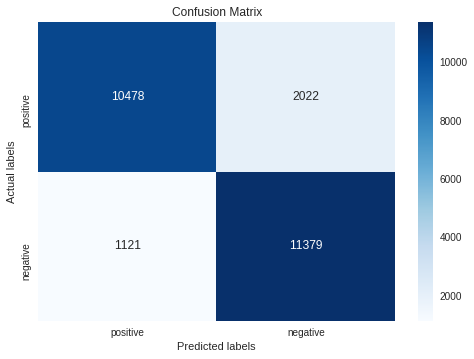

In [185]:
ax= plt.subplot()
sns.heatmap(cm_original, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['positive', 'negative']); ax.yaxis.set_ticklabels(['negative', 'positive']);

In [0]:
TP=0
FP=0
TN=0
FN=0

for i in range(len(X_test)):
  prediction = model_new.predict_classes(np.array([X_test[i]]))
  sentence_length = np.count_nonzero(X_test[i])
  prediction = prediction.astype(int)
  if prediction[0] == y_test[i]:
    if prediction[0] == 1:
      TP=TP+1
    else:
      TN=TN+1
  else:
      if prediction[0] == 0:
        FN = FN+1
      else:
        FP=FP+1

recall_modified = TP/(TP+FN)
precision_modified = TP/(TP+FP)
F1_modified=(2*recall_modified*precision_modified)/(recall_modified+precision_modified)
acc_modified = (TP+TN)/(TP+FP+TN+FN)
cm_modified = np.array([[TP,FN], [FP,TN]])

In [0]:
ax= plt.subplot()
sns.heatmap(cm_modified, annot=True, ax = ax, fmt='g', cmap='Blues'); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['positive', 'negative']); ax.yaxis.set_ticklabels(['negative', 'positive']);

In [0]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
metrics_data = {
    'metric': ['Precision', 'Precision', 'Recall', 'Recall', 'F1 Score', 'F1 Score', 'Accuracy', 'Accuracy'],
    'value': [precision_original, precision_modified, recall_original, recall_modified, F1_original, F1_modified, acc_original, acc_modified],
    'model': ['Original', 'Modified', 'Original', 'Modified', 'Original', 'Modified', 'Original', 'Modified']
}
metrics_df = pd.DataFrame(data=metrics_data)
plt.figure(figsize=(10.7, 4.27))
ax = sns.barplot(x="metric", y="value", hue="model", data=metrics_df, ci=None,palette="muted")
ax.set(xlabel='Metric', ylabel='Value')